In [1]:
# %%
import warnings

warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA


def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping


import anndata as ad
import harmonypy as hm


# %%
def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI


In [2]:
import STG3Net as MODEL

In [3]:
def get_data(proj_list, config):
    global graph_dict
    data_root = Path('D:\\project\\datasets\\DLPFC\\')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_h5ad(os.path.join(r"C:\Users\DELL\datasets\MouseEmbryo/" + proj_name + ".MOSTA.h5ad"))
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict

In [4]:
with open('../Config/Config_ME.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [5]:
proj_list = ['E9.5_E1S1', 'E10.5_E2S1', 'E11.5_E1S1']
adata, graph_dict = get_data(proj_list, config['data'])

100%|██████████| 3/3 [01:22<00:00, 27.48s/it]


In [6]:
num_cluster = 16
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [7]:
method = 'mclust'

In [8]:
net.train(method=method)

Epoch 495 total loss=1.070 recon loss=0.656 tri loss=0.000 disc loss=0.591:  50%|████▉     | 499/1000 [00:42<00:39, 12.67it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |===================================                                   |  50%

Epoch 495 total loss=1.070 recon loss=0.656 tri loss=0.000 disc loss=0.591:  50%|████▉     | 499/1000 [00:59<00:39, 12.67it/s]

  |======================================================================| 100%


Epoch 595 total loss=1.056 recon loss=0.579 tri loss=0.150 disc loss=0.617:  60%|██████    | 600/1000 [02:38<00:33, 12.01it/s]  

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=1.039 recon loss=0.555 tri loss=0.140 disc loss=0.631:  70%|██████▉   | 699/1000 [03:25<00:25, 12.02it/s]

fitting ...
  |===================================                                   |  50%

Epoch 695 total loss=1.039 recon loss=0.555 tri loss=0.140 disc loss=0.631:  70%|██████▉   | 699/1000 [03:39<00:25, 12.02it/s]

  |======================================================================| 100%


Epoch 795 total loss=1.010 recon loss=0.541 tri loss=0.136 disc loss=0.612:  80%|████████  | 800/1000 [04:30<00:16, 12.12it/s]

fitting ...
  |======================================================================| 100%


Epoch 895 total loss=0.979 recon loss=0.530 tri loss=0.130 disc loss=0.586:  90%|████████▉ | 899/1000 [05:25<00:08, 12.15it/s]

fitting ...
  |===================================                                   |  50%

Epoch 895 total loss=0.979 recon loss=0.530 tri loss=0.130 disc loss=0.586:  90%|████████▉ | 899/1000 [05:40<00:08, 12.15it/s]

  |======================================================================| 100%


Epoch 995 total loss=0.959 recon loss=0.524 tri loss=0.118 disc loss=0.571: 100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


In [9]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
print(adata)

AnnData object with n_obs × n_vars = 44531 × 5000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [10]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent',
                       key_added_pred=method, method=method)
# %%
sub_adata = adata[~pd.isnull(adata.obs['annotation'])]
ARI = ari_score(sub_adata.obs['annotation'], sub_adata.obs[method])
print(f"ARI:{ARI}")

fitting ...
  |======================================================================| 100%
ARI:0.34733595482949786


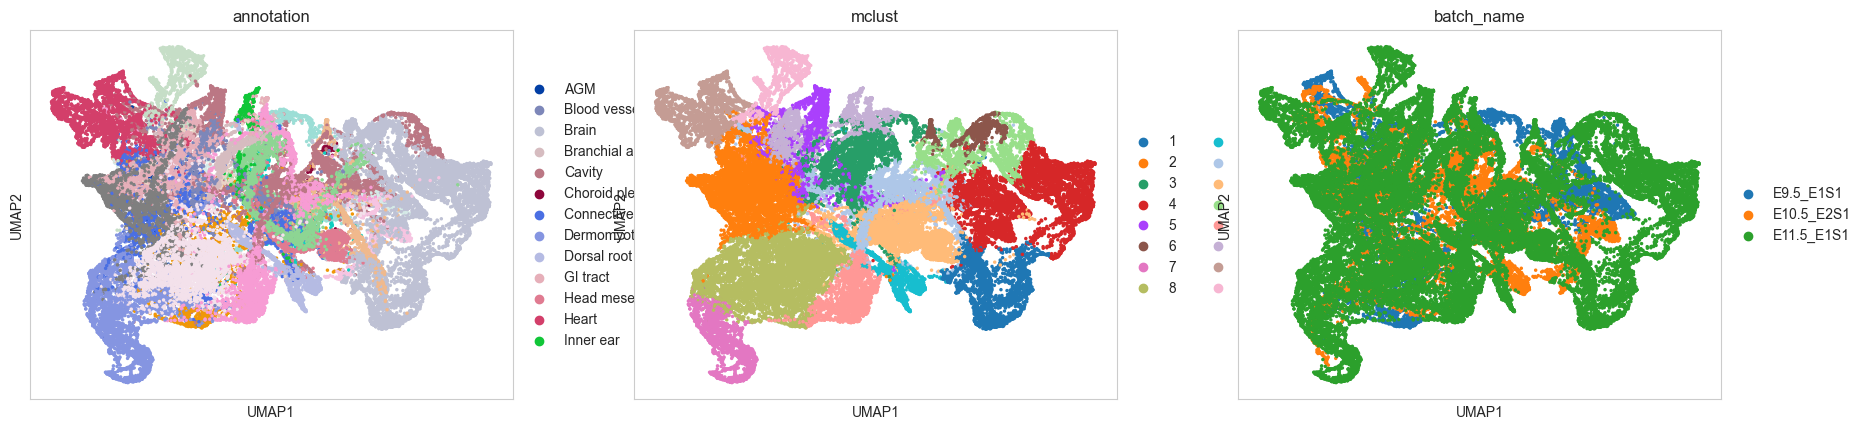

In [11]:
annotation = 'annotation'
key_pred = method
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[annotation, key_pred, 'batch_name'], show=True, size=25, save=False)

In [12]:
sub_adata = adata[~pd.isnull(adata.obs['annotation'])]
ARI = ari_score(sub_adata.obs['annotation'], sub_adata.obs[method])
print(f"ARI:{ARI}")

ARI:0.34733595482949786


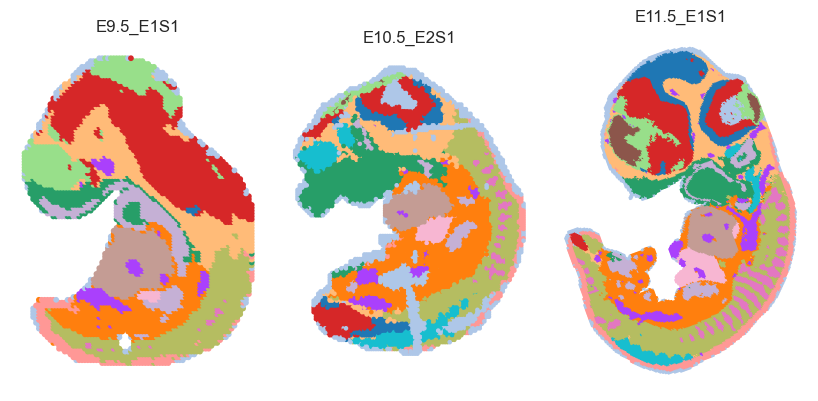

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 10))
k = 1
spot_size = 2
for slice_id, slice_name in enumerate(proj_list):
    adata_tmp = adata[adata.obs['batch_name'] == proj_list[slice_id]]
    ax = plt.subplot(2, 4, k)
    # sc.pl.embedding(adata_tmp, basis='spatial', color='annotation', s=45, ax=ax, show=False, legend_loc=False)
    sc.pl.spatial(adata_tmp, img_key=None, color=['mclust'], title=[''],
                  legend_loc=None, legend_fontsize=12, show=False, ax=ax, frameon=False,
                  spot_size=spot_size)
    plt.title(f'{slice_name}')
    k += 1
plt.tight_layout()

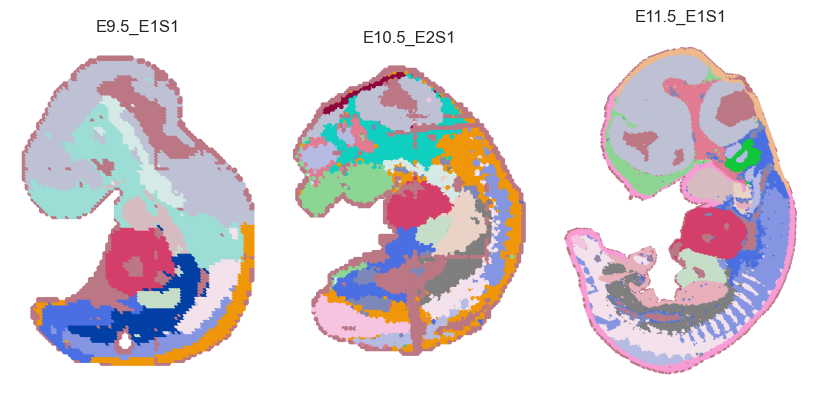

In [14]:
plt.figure(figsize=(11, 10))
k = 1
spot_size = 2
for slice_id, slice_name in enumerate(proj_list):
    adata_tmp = adata[adata.obs['batch_name'] == proj_list[slice_id]]
    ax = plt.subplot(2, 4, k)
    # sc.pl.embedding(adata_tmp, basis='spatial', color='annotation', s=45, ax=ax, show=False, legend_loc=False)
    sc.pl.spatial(adata_tmp, img_key=None, color=['annotation'], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax, frameon=False,
                         spot_size=spot_size)
    plt.title(f'{slice_name }')
    k += 1
plt.tight_layout()